In [126]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, euclidean

# Loading datasets for K-Means and HAC
small_dataset = np.load("data/small_dataset.npy")
large_dataset = np.load("data/large_dataset.npy")



In [264]:

# NOTE: You may need to add more helper functions to these classes
class KMeans(object):
    # K is the K in KMeans
    def __init__(self, K):
        self.K = K


    # X is a (N x 784) array since the dimension of each image is 28x28.
    def fit(self, X):
        # assign each point to a random cluster
        n = X.shape[0]
        d = X.shape[1]
        self.r = np.random.randint(0, self.K, (n,)) # responsibility vector
        # find prototypes

        def find_prototypes(X, r, u):
            for i in range(self.K):
                u[i] = np.mean(X[r == i], axis = 0)

        def distance(x1, x2):
            if len(x2.shape) == 2 or len(x1.shape) == 2:
                ret = np.sum((x1-x2)**2, axis = 1)
            else:
                ret = np.sum((x1-x2)**2)
            # print(ret.shape)
            return ret

        def assign_clusters(X, r, u):
            for i in range(X.shape[0]):
                r[i] = np.argmin(distance(X[i], u))

        def objective(X, r, u):
            total = 0
            for i in range(X.shape[0]):
                total += distance(X[i], u[r[i]])
            return total

        self.u = np.zeros((self.K, d))
        new_u = np.zeros((self.K, d))
        find_prototypes(X, self.r, self.u)
        objectives = []
        while True:
            objectives.append(objective(X, self.r, self.u))
        
            # assign to closest cluster
            assign_clusters(X, self.r, self.u)
            find_prototypes(X, self.r, new_u)
            # recalculate prototypes
            if np.array_equal(self.u, new_u):
                break
            self.u, new_u = new_u, self.u

        if sum([objectives[i+1] > objectives[i] for i in range(len(objectives)-1)]) == 0:
            print("Loss nonincreasing!")
        else:
            print("ERROR: Loss Increasing")
        plt.plot(objectives)
        plt.xlabel("Iteration")
        plt.xlabel("Loss")
        plt.title("Loss vs Iteration")
        plt.show()

    # This should return the arrays for K images. Each image should represent the mean of each of the fitted clusters.
    def get_mean_images(self):
        # TODO: change this!
        return self.u

    
    def plot_freq(self, n_clusters):
        # print ("PLOTTTING AOSDIJFOISW FEOI")
        plt.bar(np.arange(n_clusters), [sum(self.r == i) for i in range(n_clusters)])
        plt.show()

In [50]:
print(small_dataset.shape)
print(np.mean(small_dataset))

(300, 784)
32.81252551020408


In [69]:
r = np.random.randint(0, 10, (300,))
print(small_dataset.shape)
print(r.shape)
np.mean(small_dataset[r == 1], axis = 0).shape

(300, 784)
(300,)


(784,)

In [275]:

class HAC(object):
    def __init__(self, linkage):
        self.linkage = linkage
    
    # X is a (N x 784) array since the dimension of each image is 28x28.
    def fit(self, X):
        n = X.shape[0]
        d = X.shape[1]
        self.X = X
        self.d = d
        self.n = n
        self.r = np.zeros((n, n)).astype(int) # responsibility vector
        self.r[0] = np.arange(n).astype(int)
        # find prototypes

        def distance(x1, x2):
            
            if len(x2.shape) == 2 or len(x1.shape) == 2:
                ret = np.sqrt(np.sum((x1-x2)**2, axis = 1))
            else:
                ret = np.sqrt(np.sum((x1-x2)**2))
            return ret

        # calculate distances
        distances = np.zeros((n, n))
        for i in range(n):
            distances[i] = distance(X[i], X)

        sorted_dist = {(i, j): distance(X[i], X[j]) for j in range(n) for i in range(n)}
        sorted_dist = {k: v for k, v in sorted(sorted_dist.items(), key=lambda x: x[1])}
        # print(sorted_dist[(0, 0)], sorted_dist[(0, 1)])
        # print([(k, v) for k, v in sorted_dist.items()][:3])

        cluster_dist = np.zeros((n, n))
        for i in range(n):
            cluster_dist[i] = distance(X[i], X)

        def closest_clusters(X, r):
            indices = list(set(r))
            if self.linkage == "min":
                min_dist = 0
                closest = None
                for i in range(n):
                    for j in range(i+1, n):
                        if r[i] == r[j]:
                            continue
                        dist = distances[i, j]
                        if min_dist == 0 or dist < min_dist:
                            min_dist = dist
                            closest = (r[i], r[j])
                return closest
            if self.linkage == "max":
                # print(distances.shape)
                # print((r == i).shape)
                min_dist = 0
                closest = None
                for i, ind_i in enumerate(indices):
                    for j, ind_j in enumerate(indices):
                        if j <= i:
                            continue
                        # print(ind_i, ind_j)
                        dist = cluster_dist[ind_i, ind_j]
                        if min_dist == 0 or dist < min_dist:
                            min_dist = dist
                            closest = (ind_i, ind_j)
                return closest

            if self.linkage == "centroid":
                indices = list(set(r))
                K = len(indices)
                c = np.zeros((K, d))
                for i, ind_i in enumerate(indices):
                    c[i] = np.mean(X[r==ind_i], axis=0)
                
                min_dist = 0
                closest = None
                for i, ind_i in enumerate(indices):
                    for j, ind_j in enumerate(indices):
                        if j <= i:
                            continue
                        # print(ind_i, ind_j)
                        dist = distance(c[i], c[j])
                        if min_dist == 0 or dist < min_dist:
                            min_dist = dist
                            closest = (ind_i, ind_j)
                return closest
        def merge_clusters(r, c1, c2, iter):
            for i in range(n):
                if r[iter-1, i] == c2:
                    r[iter, i] = c1
                else:
                    r[iter, i] = r[iter-1, i]

            if self.linkage=="max":
                for i in range(n):
                    new_dist = max(cluster_dist[c1, i], cluster_dist[c2, i])
                    cluster_dist[c1, i] = new_dist
                    cluster_dist[i, c1] = new_dist
                    cluster_dist[c2, i] = new_dist
                    cluster_dist[i, c2] = new_dist

        
        for iter in range(1, n):
            # find the closest 2 clusters
            c1, c2 = closest_clusters(X, self.r[iter-1])
            # merge them
            merge_clusters(self.r, c1, c2, iter)
        


    # Returns the mean image when using n_clusters clusters
    def get_mean_images(self, n_clusters):
        # TODO: Change this!
        r = self.r[self.n - n_clusters]
        indices = list(set(r))
        assert len(indices) == n_clusters
        
        u = np.zeros((n_clusters, self.d))
        for i, x in enumerate(indices):
            u[i] = np.mean(self.X[r == x], axis = 0)
        
        return u

    
    def get_r(self, n_clusters):
        # TODO: Change this!
        r = self.r[self.n - n_clusters]
        indices = list(set(r))
        ind_to_i = {ind: i for i, ind in enumerate(indices)}
        return np.array([ind_to_i[x] for x in r])

    def plot_freq(self, n_clusters):
        r = self.r[self.n - n_clusters]
        indices = list(set(r))
        # print(indices)
        plt.bar(np.arange(n_clusters), [sum(r == indices[i]) for i in range(n_clusters)])
        plt.show()
        # print(indices)
# Plotting code for parts 2 and 3
def make_mean_image_plot(data, standardized=False):
    # Number of random restarts
    niters = 3
    K = 10
    # Will eventually store the pixel representation of all the mean images across restarts
    allmeans = np.zeros((K, niters, 784))
    for i in range(niters):
        KMeansClassifier = KMeans(K=K)
        KMeansClassifier.fit(data)
        KMeansClassifier.plot_freq(K)
        allmeans[:,i] = KMeansClassifier.get_mean_images()
    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Class mean images across random restarts' + (' (standardized data)' if standardized else ''), fontsize=16)
    for k in range(K):
        for i in range(niters):
            ax = fig.add_subplot(K, niters, 1+niters*k+i)
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)
            if k == 0: plt.title('Iter '+str(i))
            if i == 0: ax.set_ylabel('Class '+str(k), rotation=90)
            plt.imshow(allmeans[k,i].reshape(28,28), cmap='Greys_r')
    plt.show()





# TODO: Write plotting code for part 5

# TODO: Write plotting code for part 6

Loss nonincreasing!


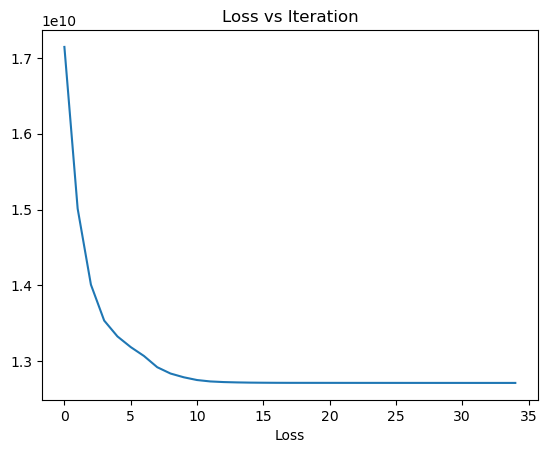

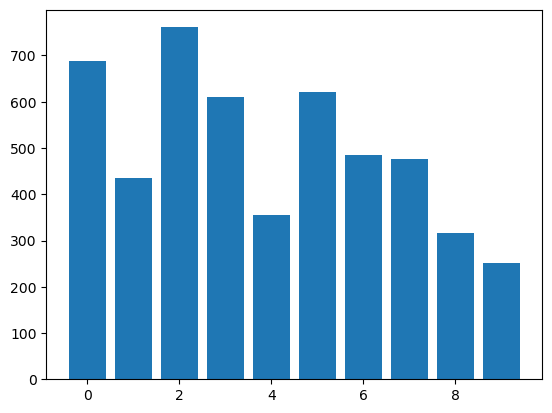

Loss nonincreasing!


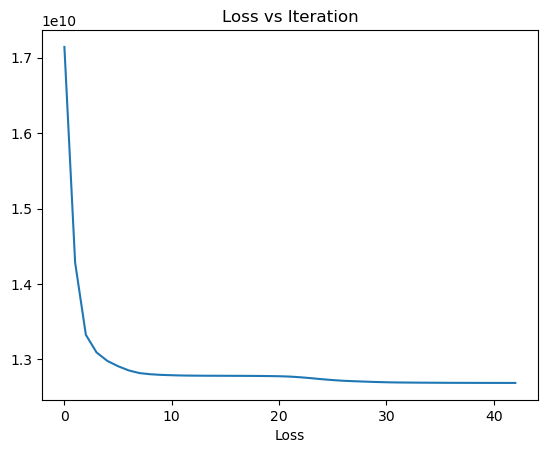

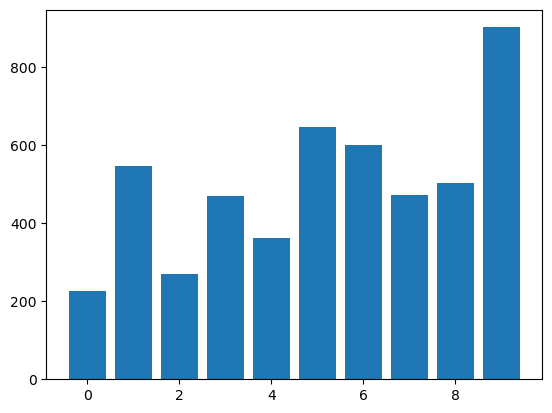

Loss nonincreasing!


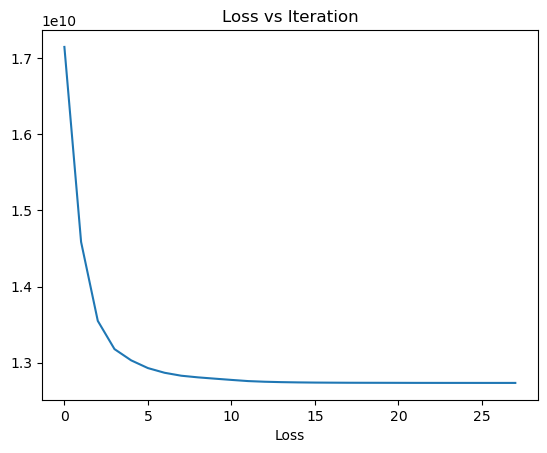

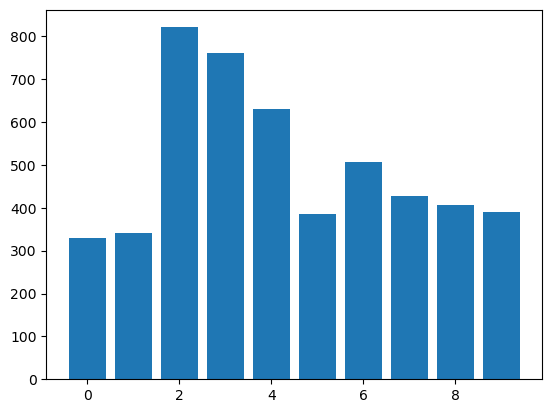

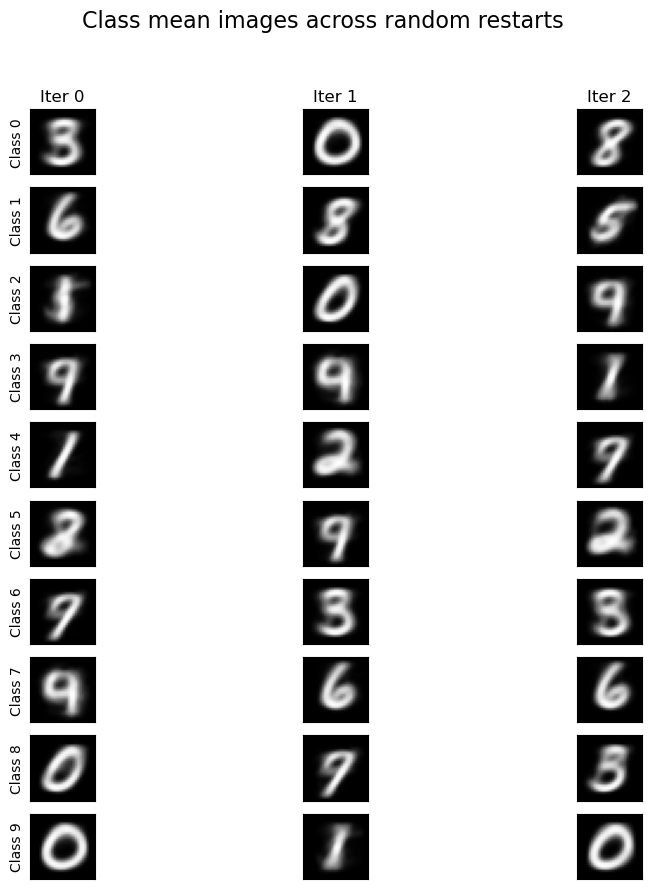

Loss nonincreasing!


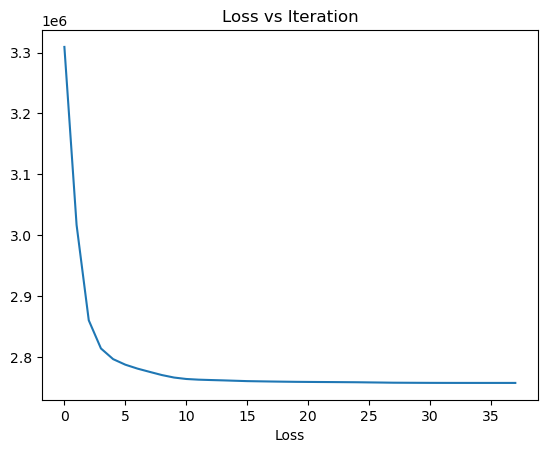

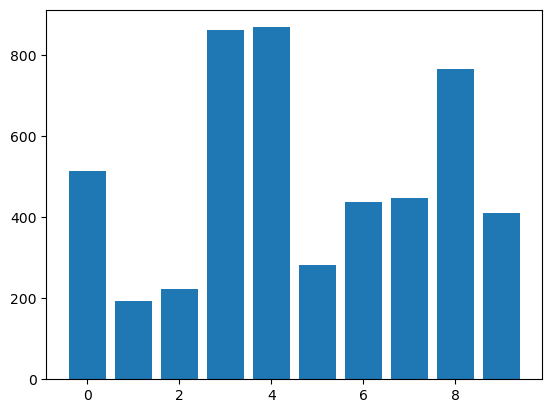

Loss nonincreasing!


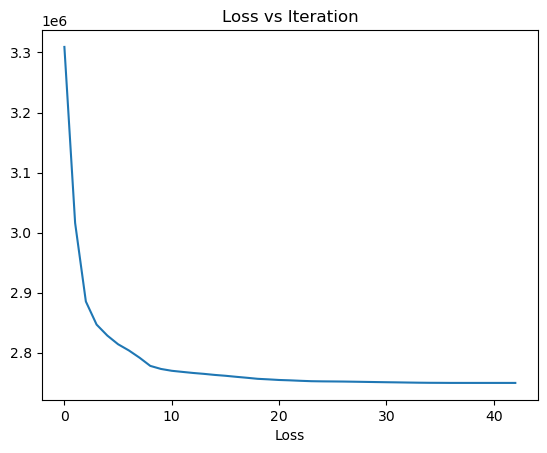

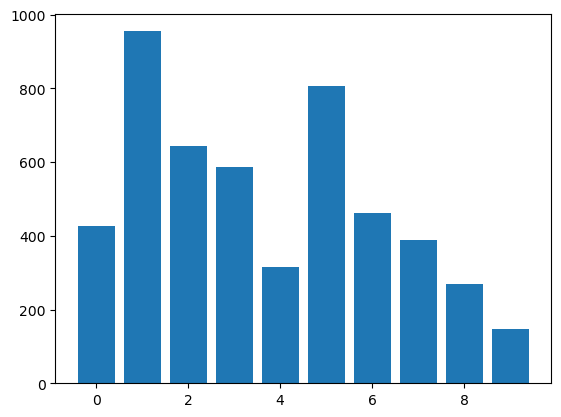

Loss nonincreasing!


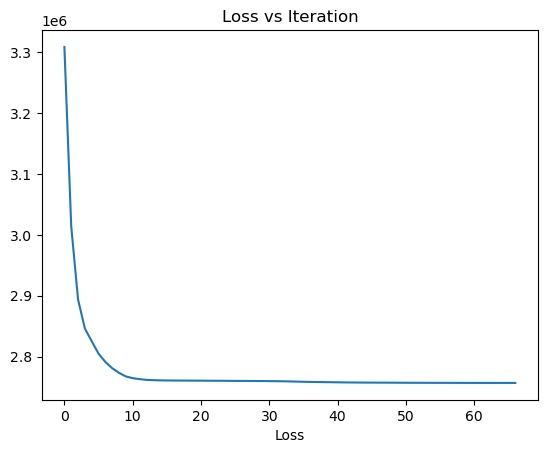

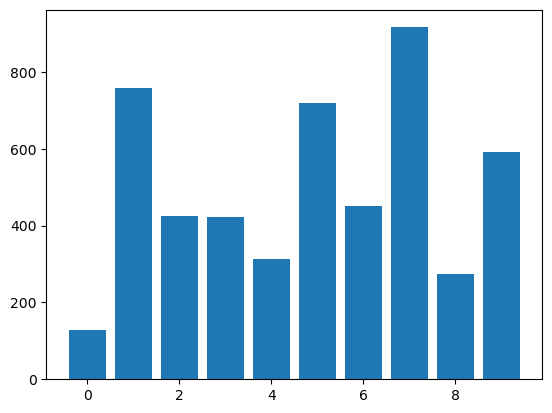

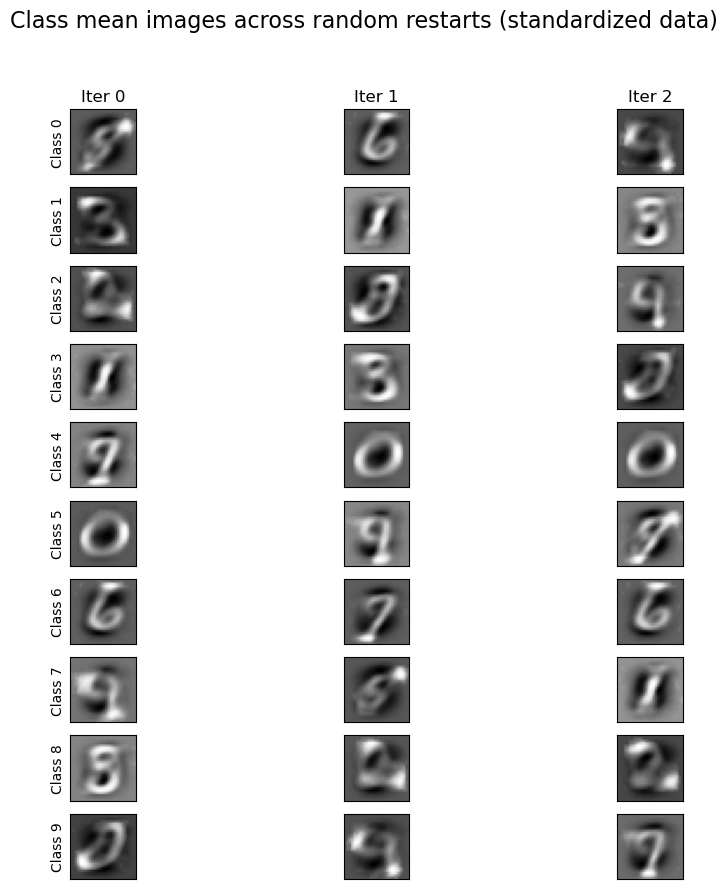

In [266]:

np.random.seed(2)
# ~~ Part 2 ~~
make_mean_image_plot(large_dataset, False)

# ~~ Part 3 ~~
# TODO: Change this line! standardize large_dataset and store the result in large_dataset_standardized
std = np.std(large_dataset, axis = 0)
std[std == 0] = 1
large_dataset_standardized = (large_dataset - np.mean(large_dataset, axis=0))/std
make_mean_image_plot(large_dataset_standardized, True)

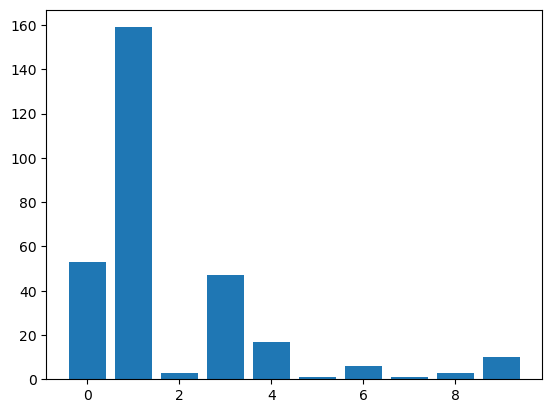

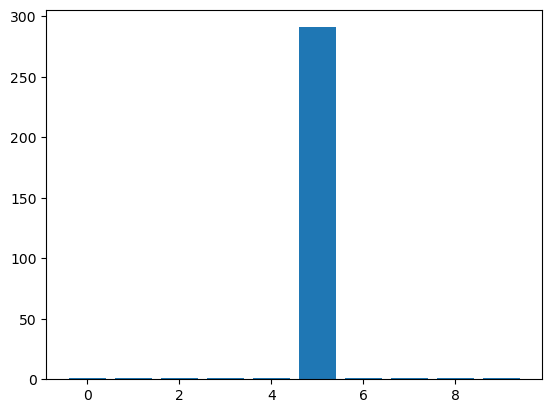

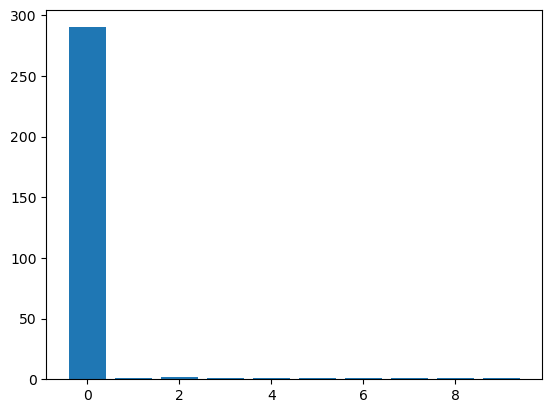

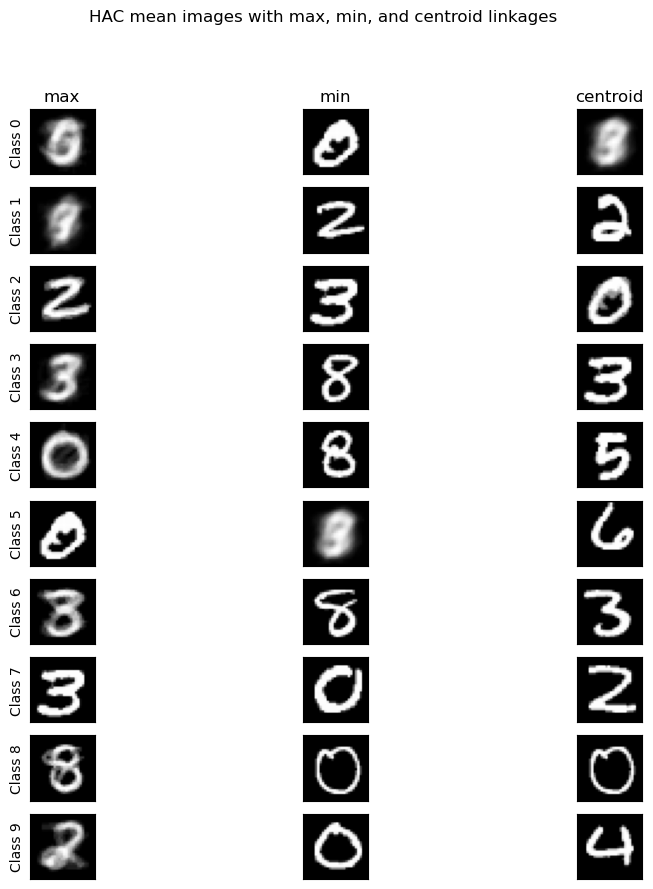

In [277]:

# Plotting code for part 4
LINKAGES = ['max', 'min', 'centroid']
n_clusters = 10

hacs = []
for l_idx, l in enumerate(LINKAGES):
    # Fit HAC
    hac = HAC(l)
    hac.fit(small_dataset)
    hac.plot_freq(n_clusters)
    hacs.append(hac)

fig = plt.figure(figsize=(10,10))
plt.suptitle("HAC mean images with max, min, and centroid linkages")

for l_idx, (l, hac) in enumerate(zip(LINKAGES, hacs)):
    mean_images = hac.get_mean_images(n_clusters)
    # Make plot
    for m_idx in range(mean_images.shape[0]):
        m = mean_images[m_idx]
        ax = fig.add_subplot(n_clusters, len(LINKAGES), l_idx + m_idx*len(LINKAGES) + 1)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        if m_idx == 0: plt.title(l)
        if l_idx == 0: ax.set_ylabel('Class '+str(m_idx), rotation=90)
        plt.imshow(m.reshape(28,28), cmap='Greys_r')
plt.show()

In [269]:
n_clusters

10

In [204]:
a = np.array([[1, 2], [3, 4], [5, 6]])
# a - np.array([10, 10, 10])
a[1, 1]

4

In [249]:
visual_dataset = np.load("P2_Autograder_Data.npy")
make_mean_image_plot(visual_dataset, standardized=False)


/Users/warren/miniconda3/envs/cs181/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/warren/miniconda3/envs/cs181/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


KeyboardInterrupt: 

In [88]:
a = np.arange(16).reshape((4, 4))
r = np.array([1, 2, 2, 1])
a[np.ix_(r == 1, r==2)]

array([[ 1,  2],
       [13, 14]])

Loss nonincreasing!


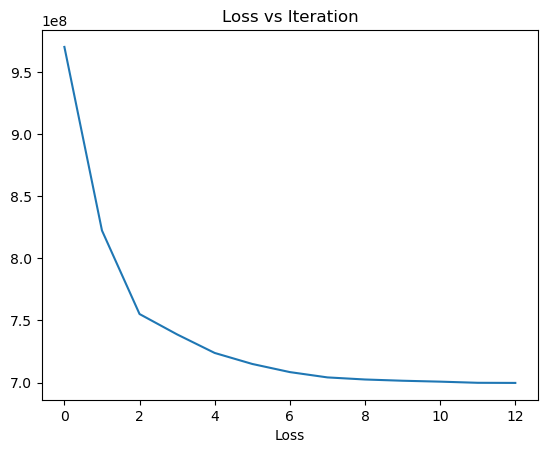

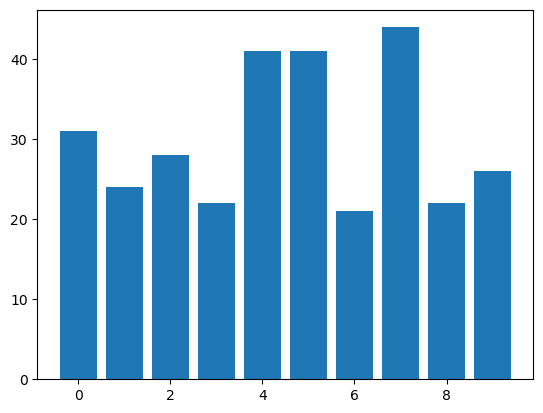

In [274]:

KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(small_dataset)
KMeansClassifier.plot_freq(10)

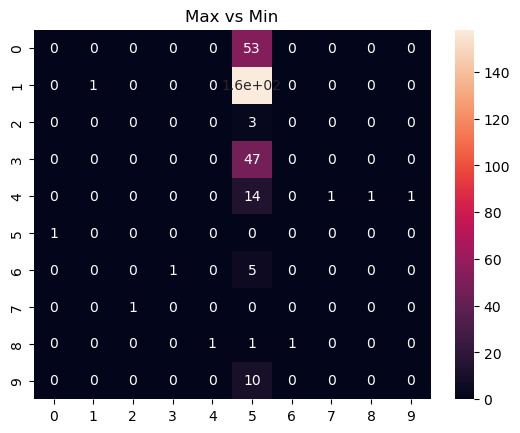

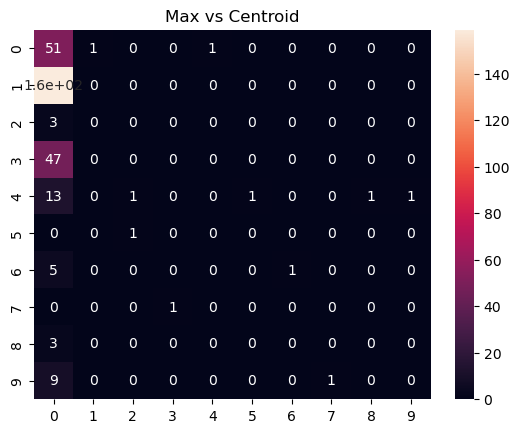

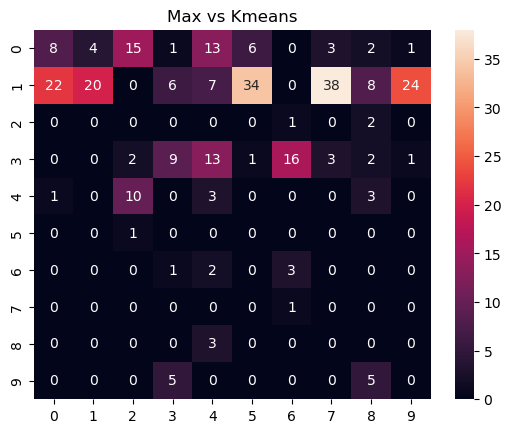

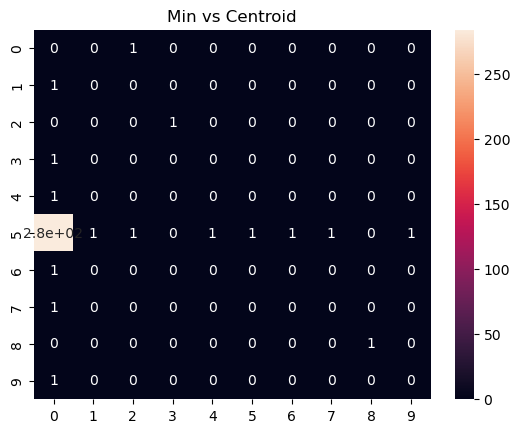

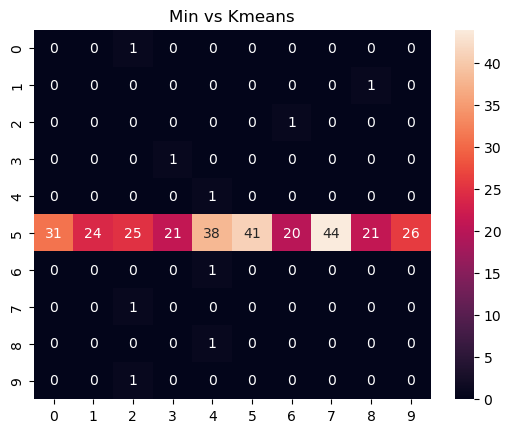

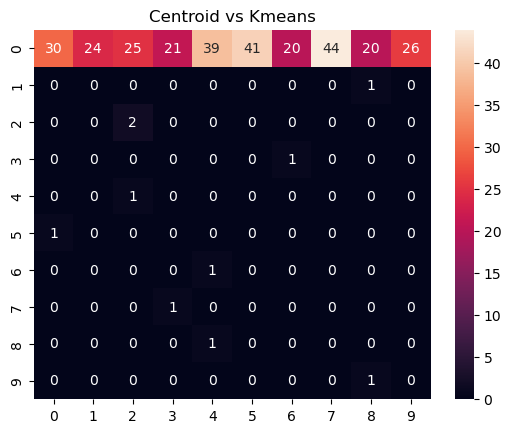

In [284]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
classifiers = hacs + [KMeansClassifier]
titles = ["Max", "Min", "Centroid", "Kmeans"]
for i in range(len(classifiers)):
    for j in range(i+1, len(classifiers)):
        c1 = classifiers[i]
        c2 = classifiers[j]
        get_r = lambda x: x.r if isinstance(x, KMeans) else x.get_r(10)
        r1 = (get_r(c1))
        r2 = get_r(c2)
        conf_mat = confusion_matrix(r1, r2)
        sn.heatmap(conf_mat, annot=True)
        plt.title(f"{titles[i]} vs {titles[j]}")
        plt.show()
